### Machine Learning Methods - protein dataset

import libraries

In [1]:
import numpy as np
import multidim
import itertools
import os
import hdbscan
import sys
import time
import pandas as pd
import itertools
import pickle
import mpi4py as MPI

from copy import deepcopy
from matplotlib.patches import Ellipse
from ripser import ripser
from persim import plot_diagrams
from numba import jit, njit, prange
from sklearn import mixture
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC, SVC
from sklearn.kernel_ridge import KernelRidge

from multidim.covertree import CoverTree
from multidim.models import CDER

import matplotlib.pyplot as plt
import ATS
from gudhi.representations.vector_methods import Landscape

from persim import PersImage
from persim import heat

sys.path.append('../persistence_methods')
import ATS
from persistence_methods import kernel_features
from persistence_methods import tent_features
from persistence_methods import carlsson_coordinates
from persistence_methods import adaptive_features
from persistence_methods import landscape_features
from persistence_methods import persistence_image_features
from persistence_methods import fast_kernel_features

import data

In [2]:
Data = pickle.load(open("persistence/diagrams.pickle", "rb"))
X_dgm0 = [d['h0'] for d in Data]
X_dgm1 = [d['h1'] for d in Data]

# We need to perturbate H_0 to use CDER.
for h0 in X_dgm0:
    h0[:,1][h0[:,1]==np.inf] = 2 # Changge all inf values in H_0 for 10.

In [8]:
Data_full = np.vstack([X_dgm0, X_dgm1])

1357


In [4]:
Data_full = np.transpose(Data_full)

In [9]:
n,p = Data_full.shape
print(n)
np_data = np.array(Data_full)
total_birth_death_pairs = 0
max_birth_death_pairs = 0
min_birth_death_pairs = 250000
for i in range(0,n):
    for j in range(0,p):
        total_birth_death_pairs += len(np_data[i,j])
        max_birth_death_pairs = max(max_birth_death_pairs,len(np_data[i,j]))
        min_birth_death_pairs = min(min_birth_death_pairs,len(np_data[i,j]))
print(total_birth_death_pairs/(n*(p)))
print(min_birth_death_pairs)
print(max_birth_death_pairs)

2
346.1978629329403
3
500


creating training index

In [10]:
train_index = np.load('data/Index/TrainIndex1.npy')
test_index = np.load('data/Index/TestIndex1.npy')
X_dgm0_train = np.array(X_dgm0, dtype=object)[train_index]
X_dgm0_test = np.array(X_dgm0, dtype=object)[test_index]
X_dgm1_train = np.array(X_dgm1, dtype=object)[train_index]
X_dgm1_test = np.array(X_dgm1, dtype=object)[test_index]
y_train = np.load('data/Index/TrainLabel1.npy')
y_test = np.load('data/Index/TestLabel1.npy')

In [15]:
y_train==1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Plot Data

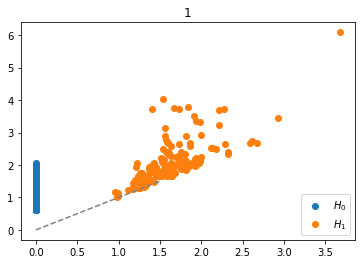

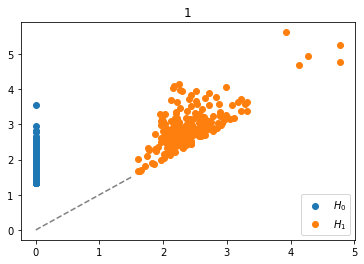

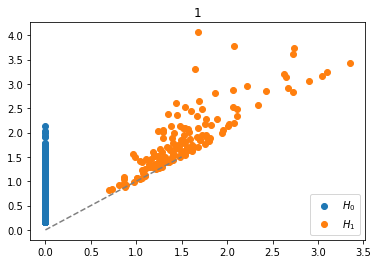

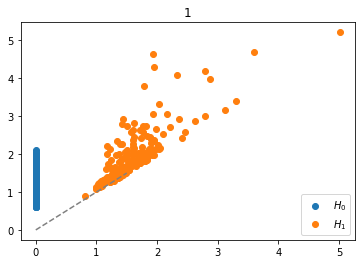

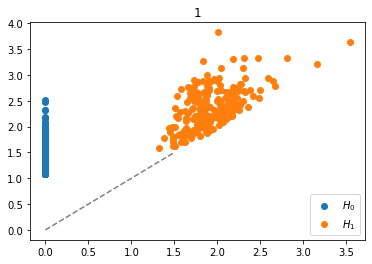

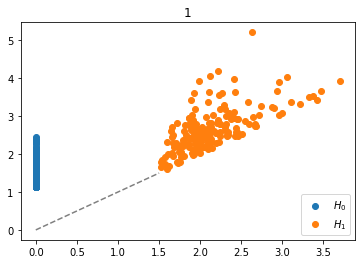

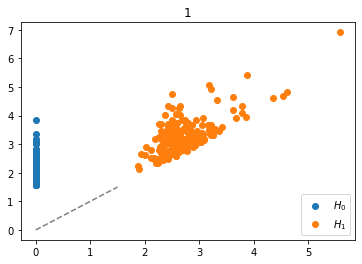

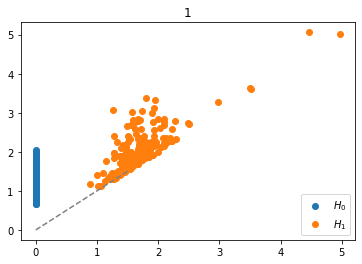

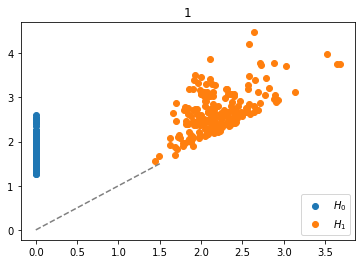

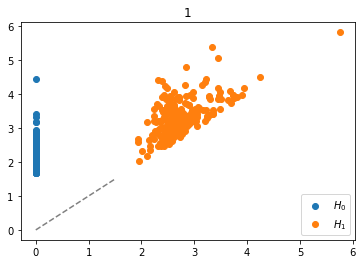

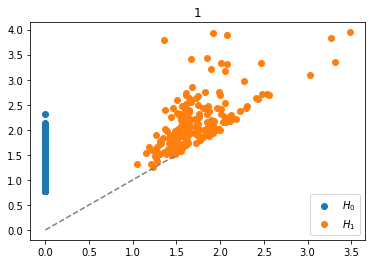

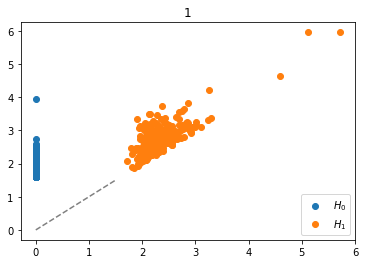

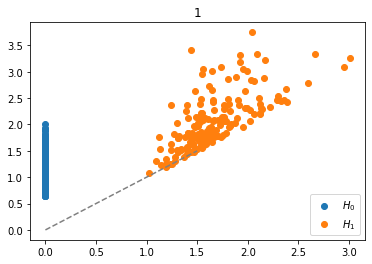

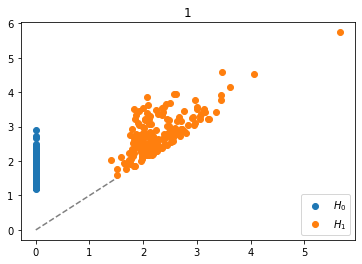

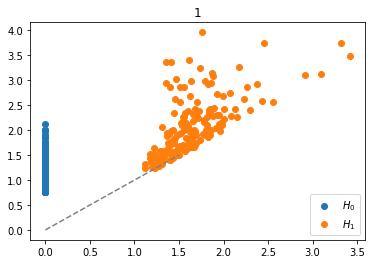

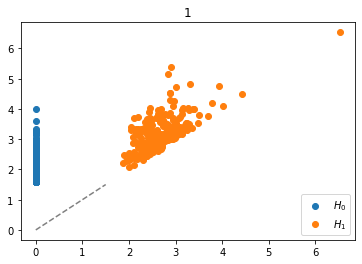

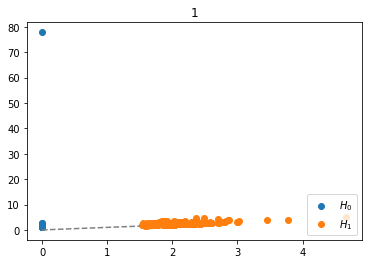

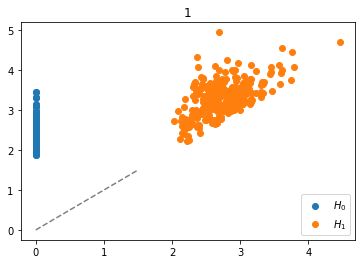

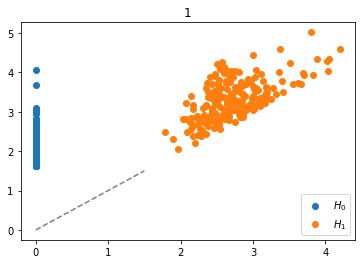

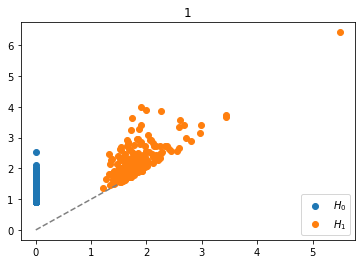

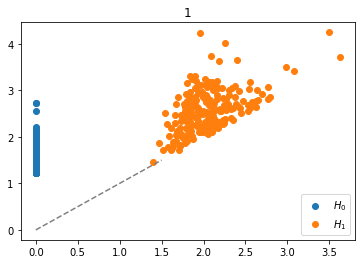

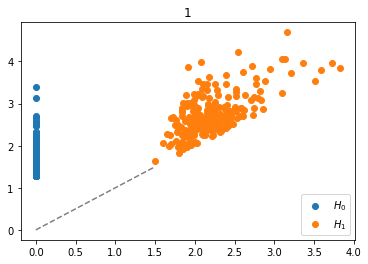

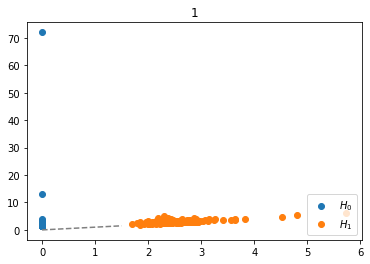

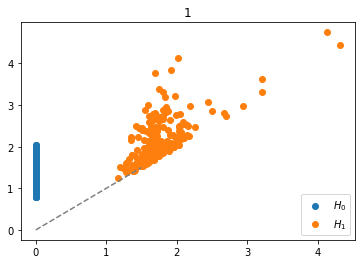

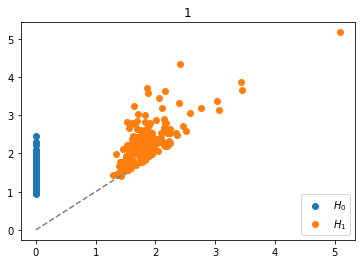

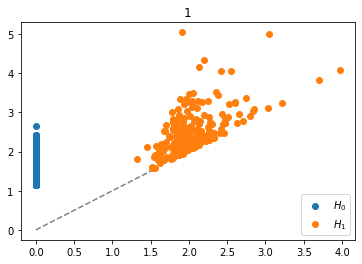

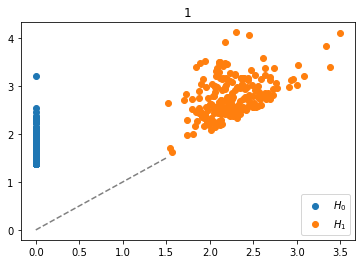

In [7]:
label = 1
label_unique = [-1,1]
labeled_X_dgm0 = []
labeled_X_dgm1 = []
for i in range(0, len(y_train)):
    if y_train[i]==label:
        labeled_X_dgm0.append(X_dgm0_train[i])
        labeled_X_dgm1.append(X_dgm1_train[i])
    else:
        0==0
for i in range(0, len(y_test)):
    if y_test[i]==label:
        labeled_X_dgm0.append(X_dgm0_test[i])
        labeled_X_dgm1.append(X_dgm1_test[i])
    else:
        0==0
        
for i in range(0,len(labeled_X_dgm0)):
    dgm0 = labeled_X_dgm0[i]
    dgm1 = labeled_X_dgm1[i]
    
    plt.scatter(dgm0[:,0], dgm0[:,1], label=r'$H_0$')
    plt.scatter(dgm1[:,0], dgm1[:,1], label=r'$H_1$')
    plt.plot(np.arange(0,1.6,0.1), np.arange(0,1.6,0.1), '--', c='gray')
    plt.legend(loc='lower right')
    plt.title(label)
    plt.show() 

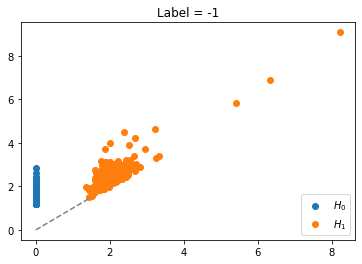

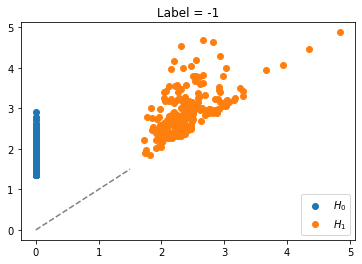

In [14]:
label = -1
label_unique = [-1,1]
labeled_X_dgm0 = []
labeled_X_dgm1 = []
for i in range(0, 1):
    if y_train[i]==label:
        labeled_X_dgm0.append(X_dgm0_train[i])
        labeled_X_dgm1.append(X_dgm1_train[i])
    else:
        0==0
for i in range(0, 1):
    if y_test[i]==label:
        labeled_X_dgm0.append(X_dgm0_test[i])
        labeled_X_dgm1.append(X_dgm1_test[i])
    else:
        0==0
        
for i in range(0,len(labeled_X_dgm0)):
    dgm0 = labeled_X_dgm0[i]
    dgm1 = labeled_X_dgm1[i]
    
    plt.scatter(dgm0[:,0], dgm0[:,1], label=r'$H_0$')
    plt.scatter(dgm1[:,0], dgm1[:,1], label=r'$H_1$')
    plt.plot(np.arange(0,1.6,0.1), np.arange(0,1.6,0.1), '--', c='gray')
    plt.legend(loc='lower right')
    plt.title("Label = " + str(label))
    plt.show() 

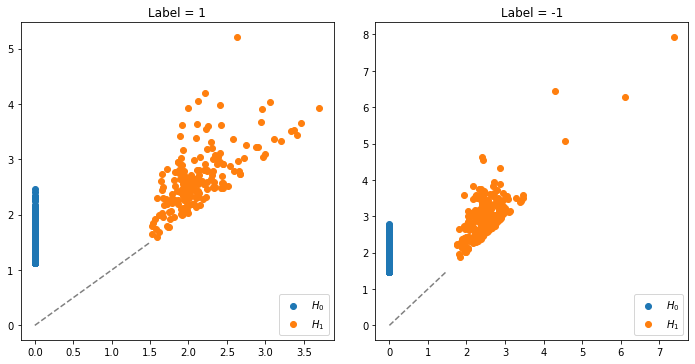

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

fig.tight_layout()


axes[0].scatter(X_dgm0_train[120][:,0], X_dgm0_train[120][:,1],label=r'$H_0$')
axes[0].scatter(X_dgm1_train[120][:,0], X_dgm1_train[120][:,1], label=r'$H_1$')
axes[0].plot(np.arange(0,1.6,0.1), np.arange(0,1.6,0.1), '--', c='gray')
axes[0].legend(loc='lower right')
axes[0].title.set_text('Label = ' + str(y_train[120]))


axes[1].scatter(X_dgm0_train[1][:,0], X_dgm0_train[1][:,1],label=r'$H_0$')
axes[1].scatter(X_dgm1_train[1][:,0], X_dgm1_train[1][:,1], label=r'$H_1$')
axes[1].plot(np.arange(0,1.6,0.1), np.arange(0,1.6,0.1), '--', c='gray')
axes[1].legend(loc='lower right')
axes[1].title.set_text('Label = ' + str(y_train[1]))
plt.show()



### Create tent functions

In [6]:
d = [10, 11, 12]
p = [.9,1,1.1,1.2]
for i in d:
    for j in p:
        X_train_features_1_tent, X_test_features_1_tent = tent_features(X_dgm1_train, X_dgm1_test, d = i, padding = j)
        X_train_features_0_tent, X_test_features_0_tent = tent_features(X_dgm0_train, X_dgm0_test, d = i, padding = j)
        X_train_features = np.column_stack((X_train_features_0_tent, X_train_features_1_tent))
        X_test_features = np.column_stack((X_test_features_0_tent, X_test_features_1_tent))
        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        print("d: ", i, "padding: ", j, "Train Accuracy: ", ridge_model.score(X_train_features, y_train), "Test Accuracy: ", ridge_model.score(X_test_features, y_test))

Computing features took (seconds):4.3052122592926025
Computing features took (seconds):9.459559917449951
d:  10 padding:  0.9 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Computing features took (seconds):4.767489910125732
Computing features took (seconds):8.928926944732666
d:  10 padding:  1 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Computing features took (seconds):4.602855205535889
Computing features took (seconds):8.790962934494019
d:  10 padding:  1.1 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Computing features took (seconds):4.782656908035278
Computing features took (seconds):9.072394847869873
d:  10 padding:  1.2 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Computing features took (seconds):5.656435012817383
Computing features took (seconds):11.119894027709961
d:  11 padding:  0.9 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Computing features t

In [8]:
X_train_features_1_tent, X_test_features_1_tent = tent_features(X_dgm1_train, X_dgm1_test, 11, 1.2)
X_train_features_0_tent, X_test_features_0_tent = tent_features(X_dgm0_train, X_dgm0_test, 11, 1.2)
X_train_features = np.column_stack((X_train_features_0_tent, X_train_features_1_tent))
X_test_features = np.column_stack((X_test_features_0_tent, X_test_features_1_tent))
ridge_model = RidgeClassifier().fit(X_train_features, y_train)
print("Train Accuracy: ", ridge_model.score(X_train_features, y_train), "Test Accuracy: ", ridge_model.score(X_test_features, y_test))

Computing features took (seconds):6.004318952560425
Computing features took (seconds):11.465693950653076
Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286


In [9]:
c = [1,2,3,5,10,20]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    print('C: ', i, "Train Accuracy: ", clf.score(X_train_features, y_train), "Test Accuracy: ", clf.score(X_test_features, y_test))

C:  1 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  2 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  3 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  5 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  10 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  20 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286


### Adaptive features GMM

In [11]:
d = [1,2,3,4]
for i in d:
    X_train_features_1_gmm, X_test_features_1_gmm = adaptive_features(X_dgm1_train, X_dgm1_test, "gmm", y_train, d=i)
    X_train_features_0_gmm, X_test_features_0_gmm = adaptive_features(X_dgm0_train, X_dgm0_test, "gmm", y_train, d=i)
    X_train_features = np.column_stack((X_train_features_0_gmm, X_train_features_1_gmm))
    X_test_features = np.column_stack((X_test_features_0_gmm, X_test_features_1_gmm))
    ridge_model = RidgeClassifier().fit(X_train_features, y_train)
    print("d: ", i, "Train Accuracy: ", ridge_model.score(X_train_features, y_train), "Test Accuracy: ", ridge_model.score(X_test_features, y_test))

Begin GMM...
Computing gmm features took (seconds):0.2579381465911865
Begin GMM...
Computing gmm features took (seconds):0.5873579978942871
d:  1 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Begin GMM...
Computing gmm features took (seconds):1.2750792503356934
Begin GMM...
Computing gmm features took (seconds):2.7181782722473145
d:  2 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Begin GMM...
Computing gmm features took (seconds):8.608154296875
Begin GMM...
Computing gmm features took (seconds):79.68433904647827
d:  3 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Begin GMM...
Computing gmm features took (seconds):18.579732179641724
Begin GMM...
Computing gmm features took (seconds):241.07608008384705
d:  4 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286


In [12]:
X_train_features_1_gmm, X_test_features_1_gmm = adaptive_features(X_dgm1_train, X_dgm1_test, "gmm", y_train, d=3)
X_train_features_0_gmm, X_test_features_0_gmm = adaptive_features(X_dgm0_train, X_dgm0_test, "gmm", y_train, d=3)
X_train_features = np.column_stack((X_train_features_0_gmm, X_train_features_1_gmm))
X_test_features = np.column_stack((X_test_features_0_gmm, X_test_features_1_gmm))
    
c = [1,2,3,5,10,20]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    print('C: ', i, "Train Accuracy: ", clf.score(X_train_features, y_train), "Test Accuracy: ", clf.score(X_test_features, y_test))

Begin GMM...
Computing gmm features took (seconds):6.51821494102478
Begin GMM...
Computing gmm features took (seconds):75.65530800819397
C:  1 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  2 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  3 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  5 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  10 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  20 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286


### HDB Scan

In [13]:
X_train_features_1_hdb, X_test_features_1_hdb = adaptive_features(X_dgm1_train, X_dgm1_test, "hdb", y_train)
X_train_features_0_hdb, X_test_features_0_hdb = adaptive_features(X_dgm0_train, X_dgm0_test, "hdb", y_train)
X_train_features = np.column_stack((X_train_features_0_hdb, X_train_features_1_hdb))
X_test_features = np.column_stack((X_test_features_0_hdb, X_test_features_1_hdb))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)
print("Train Accuracy: ", ridge_model.score(X_train_features, y_train), "Test Accuracy: ", ridge_model.score(X_test_features, y_test))

Begin HDBSCAN...
Computing hdbscan features took (seconds):542.3290660381317
Begin HDBSCAN...


/Users/barnesd8/Documents/git/machine_learning_persistence/protein/ATS.py:517: RuntimeWarning: divide by zero encountered in power
  sigma = np.diag(np.power(axis, -2))
/Users/barnesd8/Documents/git/machine_learning_persistence/protein/ATS.py:519: RuntimeWarning: invalid value encountered in matmul
  temp = x_centered@rotation@sigma@np.transpose(rotation)@np.transpose(x_centered)


KeyboardInterrupt: 

In [7]:
c = [1,2,3,5,10,20]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    print('C: ', i, "Train Accuracy: ", clf.score(X_train_features, y_train), "Test Accuracy: ", clf.score(X_test_features, y_test))

Begin HDBSCAN...
Computing hdbscan features took (seconds):522.9976260662079


### CDER

In [27]:
X_train_features_1_cder, X_test_features_1_cder = adaptive_features(X_dgm1_train, X_dgm1_test, "cder", y_train)
X_train_features_0_cder, X_test_features_0_cder = adaptive_features(X_dgm0_train, X_dgm0_test, "cder", y_train)
X_train_features = np.column_stack((X_train_features_0_cder, X_train_features_1_cder))
X_test_features = np.column_stack((X_test_features_0_cder, X_test_features_1_cder))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)
print("Train Accuracy: ", ridge_model.score(X_train_features, y_train), "Test Accuracy: ", ridge_model.score(X_test_features, y_test))

Begin CDER...
Computing features from H_1 took (seconds):93.98860692977905
Begin CDER...


Computing features from H_1 took (seconds):23.369328022003174
Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286


In [28]:
c = [1,2,3,5,10,20]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    print('C: ', i, "Train Accuracy: ", clf.score(X_train_features, y_train), "Test Accuracy: ", clf.score(X_test_features, y_test))

C:  1 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  2 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  3 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  5 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  10 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  20 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286


### Persistence Images

In [17]:
pixels = [[15,15],[20,20],[25,25],[30,30],[35,35],[40,40]]
spread = [.5,1]
for p in pixels:
    for s in spread:
        X_train_features_1_imgs, X_test_features_1_imgs = persistence_image_features(X_dgm1_train, X_dgm1_test, pixels=p, spread=s)
        X_train_features_0_imgs, X_test_features_0_imgs = persistence_image_features(X_dgm0_train, X_dgm0_test, pixels = p, spread=s)
        X_train_features = np.column_stack((X_train_features_1_imgs,X_train_features_0_imgs))
        X_test_features = np.column_stack((X_test_features_1_imgs,X_test_features_0_imgs))
        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        print("Pixels: ", p, "Spread: ", s, "Train Accuracy: ", ridge_model.score(X_train_features, y_train), "Test Accuracy: ", ridge_model.score(X_test_features, y_test))

PersImage(pixels=[15, 15], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  80.24459791183472
PersImage(pixels=[15, 15], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  208.30018305778503
Pixels:  [15, 15] Spread:  0.5 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
PersImage(pixels=[15, 15], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  83.25131392478943
PersImage(pixels=[15, 15], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[15, 15], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time: 

KeyboardInterrupt: 

In [18]:
X_train_features_1_imgs, X_test_features_1_imgs = persistence_image_features(X_dgm1_train, X_dgm1_test)
X_train_features_0_imgs, X_test_features_0_imgs = persistence_image_features(X_dgm0_train, X_dgm0_test)
X_train_features = np.column_stack((X_train_features_1_imgs,X_train_features_0_imgs))
X_test_features = np.column_stack((X_test_features_1_imgs,X_test_features_0_imgs))

PersImage(pixels=[20, 20], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[20, 20], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  90.23216223716736
PersImage(pixels=[20, 20], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
PersImage(pixels=[20, 20], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")
Total Time:  236.10686898231506


In [19]:
clf = SVC(kernel='rbf').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


### Landscapes

In [20]:
n = [2,3,4,5,6,7,8,9,10]
r = [50,100,200,300,400,500]
for i in n:
    for j in r:
        X_train_features_1_landscapes, X_test_features_1_landscapes = landscape_features(X_dgm1_train, X_dgm1_test, num_landscapes=i, resolution=j)
        X_train_features_0_landscapes, X_test_features_0_landscapes = landscape_features(X_dgm0_train, X_dgm0_test, num_landscapes=i, resolution=j)
        X_train_features = np.column_stack((X_train_features_0_landscapes, X_train_features_1_landscapes))
        X_test_features = np.column_stack((X_test_features_0_landscapes, X_test_features_1_landscapes))
        ridge_model = RidgeClassifier().fit(X_train_features, y_train)
        print("Number Landscapes: ", i, "Resolution: ", j, "Train Accuracy: ", ridge_model.score(X_train_features, y_train), "Test Accuracy: ", ridge_model.score(X_test_features, y_test))

Total Time:  18.81610107421875
Total Time:  48.574077129364014
Number Landscapes:  2 Resolution:  50 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Total Time:  19.26957106590271
Total Time:  47.12366700172424
Number Landscapes:  2 Resolution:  100 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Total Time:  19.081465005874634
Total Time:  48.211747884750366
Number Landscapes:  2 Resolution:  200 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Total Time:  19.464409112930298
Total Time:  48.750816106796265
Number Landscapes:  2 Resolution:  300 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Total Time:  19.355093955993652
Total Time:  49.5651650428772
Number Landscapes:  2 Resolution:  400 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Total Time:  20.025943994522095
Total Time:  49.0545220375061
Number Landscapes:  2 Resolution:  500 Train Accuracy:  0.9693430656934306

Total Time:  17.151697874069214
Total Time:  43.28708577156067
Number Landscapes:  10 Resolution:  50 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Total Time:  17.050935745239258
Total Time:  43.74124884605408
Number Landscapes:  10 Resolution:  100 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
Total Time:  17.764052867889404
Total Time:  43.42943000793457
Number Landscapes:  10 Resolution:  200 Train Accuracy:  0.9708029197080292 Test Accuracy:  0.9910714285714286
Total Time:  17.634426832199097
Total Time:  43.501786947250366
Number Landscapes:  10 Resolution:  300 Train Accuracy:  0.9708029197080292 Test Accuracy:  0.9910714285714286
Total Time:  17.855270862579346
Total Time:  44.34421992301941
Number Landscapes:  10 Resolution:  400 Train Accuracy:  0.9708029197080292 Test Accuracy:  0.9895833333333334
Total Time:  18.460668802261353
Total Time:  45.14991998672485
Number Landscapes:  10 Resolution:  500 Train Accuracy:  0.97372262

In [21]:
X_train_features_1_landscapes, X_test_features_1_landscapes = landscape_features(X_dgm1_train, X_dgm1_test, num_landscapes=5, resolution=300)
X_train_features_0_landscapes, X_test_features_0_landscapes = landscape_features(X_dgm0_train, X_dgm0_test, num_landscapes=5, resolution=300)
X_train_features = np.column_stack((X_train_features_0_landscapes, X_train_features_1_landscapes))

X_test_features = np.column_stack((X_test_features_0_landscapes, X_test_features_1_landscapes))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with landscapes functions')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Total Time:  17.507066249847412
Total Time:  43.88808488845825
Train/test classification accuracy with landscapes functions
0.9708029197080292
0.9910714285714286


### Kernel

In [23]:
sigma = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1]
for s in sigma:
    X_train_features_1_kernel, X_test_features_1_kernel = fast_kernel_features(X_dgm1_train, X_dgm1_test, s)
    svc_model = SVC(kernel='precomputed')
    svc_model.fit(X_train_features_1_kernel, y_train)
    print("Sigma: ", s, "Train Accuracy: ", svc_model.score(X_train_features_1_kernel, y_train), "Test Accuracy: ", svc_model.score(X_test_features_1_kernel, y_test))

Total Time:  2508.1714701652527
Sigma:  0.05 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.9717261904761905
Total Time:  2517.683072090149
Sigma:  0.1 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.9672619047619048
Total Time:  2422.9162118434906
Sigma:  0.15 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.96875
Total Time:  2494.859377145767
Sigma:  0.2 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.9657738095238095
Total Time:  2496.869436264038
Sigma:  0.25 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.9702380952380952
Total Time:  2436.155217885971
Sigma:  0.3 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.96875
Total Time:  2432.3581659793854
Sigma:  0.35 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.9642857142857143
Total Time:  2437.809566259384
Sigma:  0.4 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.9642857142857143
Total Time:  2425.6660900115967
Sigma:  0.45 Train Accuracy:  0.9386861313868613 Test Accuracy:  0.9642

### Carlsson Coordinates

In [24]:
X_train_features1_cc1, X_train_features1_cc2, X_train_features1_cc3, X_train_features1_cc4, X_test_features1_cc1, X_test_features1_cc2, X_test_features1_cc3, X_test_features1_cc4 = carlsson_coordinates(X_dgm1_train, X_dgm1_test)
X_train_features0_cc1, X_train_features0_cc2, X_train_features0_cc3, X_train_features0_cc4, X_test_features0_cc1, X_test_features0_cc2, X_test_features0_cc3, X_test_features0_cc4 = carlsson_coordinates(X_dgm0_train, X_dgm0_test)

Total Time:  0.18705511093139648
Total Time:  0.4858591556549072


In [25]:
X_train_features = np.column_stack((X_train_features1_cc1, X_train_features1_cc2, X_train_features1_cc3, X_train_features1_cc4,
                                   X_train_features0_cc1, X_train_features0_cc2, X_train_features0_cc3, X_train_features0_cc4))

X_test_features = np.column_stack((X_test_features1_cc1,X_test_features1_cc2, X_test_features1_cc3,X_test_features1_cc4,
                                  X_test_features0_cc1,X_test_features0_cc2, X_test_features0_cc3,X_test_features0_cc4))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.06248e-18): result may not be accurate.
  overwrite_a=True).T


In [26]:
c = [.5,.6,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.5,5,10,15,20,50]
for i in c:
    clf = SVC(kernel='rbf', C=i).fit(X_train_features, y_train)
    print('C: ', i, "Train Accuracy: ", clf.score(X_train_features, y_train), "Test Accuracy: ", clf.score(X_test_features, y_test))

C:  0.5 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  0.6 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  0.7 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  0.8 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  0.9 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  1 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  1.1 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  1.2 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  1.3 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  1.4 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  1.5 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  1.6 Train Accuracy:  0.9693430656934306 Test Accuracy:  0.9910714285714286
C:  1.7 Train Accuracy:  0.9693430656934306 Test Accur

### Tent Functions

In [43]:
# -----------------------------------------------------------------------------
# ------------------------------ Ridge Classification  ------------------------
# -----------------------------------------------------------------------------

X_train_features = np.column_stack((X_train_features_0, X_train_features_1_tent))

X_test_features = np.column_stack((X_test_features_0, X_test_features_1_tent))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with tent functions')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with tent functions
0.9693430656934306
0.9910714285714286


In [44]:
clf = SVC(kernel='rbf').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


In [45]:
clf = SVC(kernel='poly').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


### GMM

In [48]:
# -----------------------------------------------------------------------------
# ------------------------------ Ridge Classification  ------------------------
# -----------------------------------------------------------------------------

X_train_features = np.column_stack((X_train_features_0, X_train_features_1_gmm))

X_test_features = np.column_stack((X_test_features_0, X_test_features_1_gmm))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with Gaussian Mixture Models adaptive templates')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with Gaussian Mixture Models adaptive templates
0.9693430656934306
0.9910714285714286


In [49]:
clf = SVC(kernel='rbf').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


### HDB Scan

In [50]:
# -----------------------------------------------------------------------------
# ------------------------------ Ridge Classification  ------------------------
# -----------------------------------------------------------------------------

X_train_features = np.column_stack((X_train_features_0, X_train_features_1_hdb))

X_test_features = np.column_stack((X_test_features_0, X_test_features_1_hdb))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with HDBSCAN adaptive templates')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with HDBSCAN adaptive templates
1.0
0.9910714285714286


In [51]:
clf = SVC(kernel='rbf').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


### CDER

In [52]:
X_train_features = np.column_stack((X_train_features_0, X_train_features_1_cder))

X_test_features = np.column_stack((X_test_features_0, X_test_features_1_cder))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with HDBSCAN adaptive templates')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with HDBSCAN adaptive templates
0.9693430656934306
0.9910714285714286


In [53]:
clf = SVC(kernel='rbf').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


### Persistence Images

In [55]:
X_train_features = np.column_stack((X_train_features_0_imgs, X_train_features_1_imgs))

X_test_features = np.column_stack((X_test_features_0_imgs, X_test_features_1_imgs))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


In [56]:
clf = SVC(kernel='rbf').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


### Landscapes

In [57]:
X_train_features = np.column_stack((X_train_features_0_landscapes, X_train_features_1_landscapes))

X_test_features = np.column_stack((X_test_features_0_landscapes, X_test_features_1_landscapes))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with landscapes functions')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with landscapes functions
0.9693430656934306
0.9910714285714286


In [58]:
clf = SVC(kernel='rbf').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


### Kernel

In [21]:
#X_train_features = np.column_stack((X_train_features_0, X_train_features_1_kernel))

#X_test_features = np.column_stack((X_test_features_0, X_test_features_1_kernel))

ridge_model = KernelRidge(kernel='precomputed').fit(X_train_features_1_kernel, y_train)

print('Train/test classification accuracy with kernel functions')
#print(ridge_model.predict(X_train_features_1_kernel))
print(ridge_model.score(X_test_features_1_kernel, y_test))

Train/test classification accuracy with kernel functions
-23757.40507782672


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [22]:
svc_model = SVC(kernel='precomputed')
svc_model.fit(X_train_features_1_kernel, y_train)

print('Train/test classification accuracy with kernel functions')
print(svc_model.score(X_train_features_1_kernel, y_train))
print(svc_model.score(X_test_features_1_kernel, y_test))

Train/test classification accuracy with kernel functions
0.9386861313868613
0.9642857142857143


### Carlsson Coordinates

In [23]:
X_train_features = np.column_stack((X_train_features1_cc1, X_train_features1_cc2, X_train_features1_cc3, X_train_features1_cc4,
                                   X_train_features0_cc1, X_train_features0_cc2, X_train_features0_cc3, X_train_features0_cc4))

X_test_features = np.column_stack((X_test_features1_cc1,X_test_features1_cc2, X_test_features1_cc3,X_test_features1_cc4,
                                  X_test_features0_cc1,X_test_features0_cc2, X_test_features0_cc3,X_test_features0_cc4))

ridge_model = RidgeClassifier().fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(ridge_model.score(X_train_features, y_train))
print(ridge_model.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286


/Users/barnesd8/Documents/git/machine_learning_persistence/env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.06248e-18): result may not be accurate.
  overwrite_a=True).T


In [24]:
clf = SVC(kernel='rbf').fit(X_train_features, y_train)

print('Train/test classification accuracy with persistence functions')
print(clf.score(X_train_features, y_train))
print(clf.score(X_test_features, y_test))

Train/test classification accuracy with persistence functions
0.9693430656934306
0.9910714285714286
